In [2]:
import jax

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")

import jax.numpy as jnp
from jax import Array

import numpy as np

In [17]:
from xpektra import SpectralSpace, make_field
from xpektra.transform import FFTTransform
from xpektra.scheme import RotatedDifference
from xpektra.spectral_operator import SpectralOperator
from xpektra.projection_operator import GalerkinProjection

from xpektra.solvers.nonlinear import (  # noqa: E402
    newton_krylov_solver,
    conjugate_gradient_while,
)


import equinox as eqx
import matplotlib.pyplot as plt 
from skimage.morphology import rectangle

## constructing a dual phase RVE

/tmp/ipykernel_94332/3980638497.py:8: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  structure[:r, -r:] += rectangle(r, r)


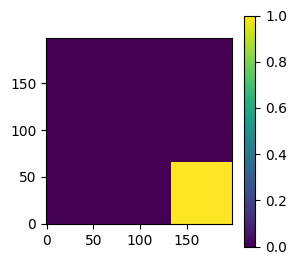

In [33]:
ndim = 2
N = 199
length = 1.0

r = int(N / 3)

structure = np.zeros((N, N))
structure[:r, -r:] += rectangle(r, r)

plt.figure(figsize=(3, 3))
cb = plt.imshow(structure, origin="lower")
plt.colorbar(cb)
plt.show()

In [34]:
fft_transform = FFTTransform(dim=ndim)
space = SpectralSpace(
    lengths=(length,) * ndim, shape=structure.shape, transform=fft_transform
)
rotated_scheme = RotatedDifference(space=space)

op = SpectralOperator(
    scheme=rotated_scheme,
    space=space,
)

Ghat = GalerkinProjection(scheme=rotated_scheme)
dofs_shape = make_field(dim=ndim, shape=structure.shape, rank=2).shape

In [35]:
E1 = 0.57
E2 = 5.7   
nu1 = 0.386
nu2 = 0.386

lambda1 = E1 * nu1 / ((1 + nu1) * (1 - 2 * nu1))
mu1 = E1 / (2 * (1 + nu1))

lambda2 = E2 * nu2 / ((1 + nu2) * (1 - 2 * nu2))
mu2 = E2 / (2 * (1 + nu2))


lambdas = lambda1 * (1.0 - structure) + lambda2 * structure
mus = mu1 * (1.0 - structure) + mu2 * structure

In [36]:
i = jnp.eye(ndim)
I = make_field(dim=ndim, shape=structure.shape, rank=2) + i

@eqx.filter_jit
def green_lagrange_strain(F: Array) -> Array:
    return 0.5 * (op.dot(op.trans(F), F) - I)


@eqx.filter_jit
def strain_energy(F_flat: Array) -> float:
    F = F_flat.reshape(dofs_shape)
    E = green_lagrange_strain(F)
    E = 0.5 * (E + op.trans(E))
    energy = 0.5 * jnp.multiply(lambdas, op.trace(E) ** 2) + jnp.multiply(
        mus, op.trace(op.dot(E, E))
    )
    return energy.sum()


compute_stress = jax.jacrev(strain_energy)


In [37]:
class Residual(eqx.Module):
    """A callable module that computes the residual vector."""

    Ghat: Array
    dofs_shape: tuple = eqx.field(static=True)

    # We can even pre-define the stress function if it's always the same
    # For this example, we'll keep your original `compute_stress` function
    # available in the global scope.

    @eqx.filter_jit
    def __call__(self, eps_flat: Array) -> Array:
        """
        This makes instances of this class behave like a function.
        It takes only the flattened vector of unknowns, as required by the solver.
        """
        eps_flat = eps_flat.reshape(-1)
        sigma = compute_stress(eps_flat)
        residual_field = op.inverse(
            Ghat.project(op.forward(sigma.reshape(self.dofs_shape)))
        )
        return jnp.real(residual_field).reshape(-1)


class Jacobian(eqx.Module):
    """A callable module that represents the Jacobian operator (tangent)."""

    Ghat: Array
    dofs_shape: tuple = eqx.field(static=True)

    @eqx.filter_jit
    def __call__(self, deps_flat: Array, eps_flat: Array) -> Array:
        """
        The Jacobian is a linear operator, so its __call__ method
        represents the Jacobian-vector product.
        """

        deps_flat = deps_flat.reshape(-1)
        dsigma = jax.jvp(compute_stress, (eps_flat,), (deps_flat,))[1]
        jvp_field = op.inverse(
            Ghat.project(op.forward(dsigma.reshape(self.dofs_shape)))
        )
        return jnp.real(jvp_field).reshape(-1)

In [38]:
F = make_field(dim=ndim, shape=structure.shape, rank=2)
F[:, :, 0, 0] = 1
F[:, :, 1, 1] = 1

residual_fn = Residual(Ghat=Ghat, dofs_shape=F.shape)
jacobian_fn = Jacobian(Ghat=Ghat, dofs_shape=F.shape)


dF = make_field(dim=ndim, shape=structure.shape, rank=2)

applied_strains = jnp.diff(jnp.linspace(0, 0.1, num=3))
print(applied_strains)

for inc, dF_avg in enumerate(applied_strains):
    # solving for elasticity
    dF[:, :, 0, 1] = dF_avg
    b = -jacobian_fn(dF.reshape(-1), F.reshape(-1))
    F = F + dF

    jacobian_partial = eqx.Partial(jacobian_fn, eps_flat=F.reshape(-1))

    final_state = newton_krylov_solver(
        state=(dF, b, F),
        gradient=residual_fn,
        jacobian=jacobian_partial,
        tol=1e-6,
        max_iter=20,
        krylov_solver=conjugate_gradient_while,
        krylov_tol=1e-6,
        krylov_max_iter=20,
    )
    F = final_state[2]

    print("step", inc, "time", inc)


P = compute_stress(F.reshape(-1)).reshape(dofs_shape)


[0.05 0.05]
CG error = 33.19460615172127
CG error = 1.28971011521594
CG error = 0.00118017565250
CG error = 0.00001757595715
CG error = 0.00000001968825
CG error = 0.00000000026227
CG error = 0.00000000000142
Converged, Residual value : 4.698133343089268e-07
step 0 time 0
CG error = 33.59525747060275
CG error = 1.27580292429010
CG error = 0.00111271726728
CG error = 0.00001635449326
CG error = 0.00000001720227
CG error = 0.00000000023112
CG error = 0.00000000000145
Converged, Residual value : 5.635722872674555e-07
step 1 time 1


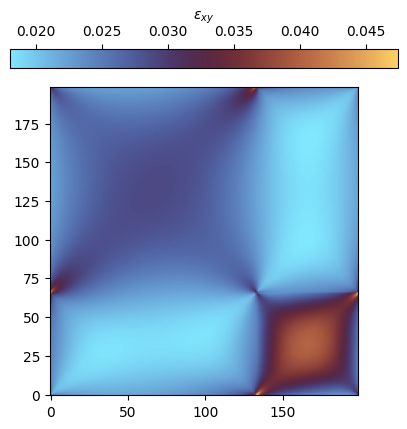

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = plt.axes()
cax = ax.imshow(P.at[:, :, 0, 1].get(), cmap="managua_r", origin="lower")
fig.colorbar(cax, label=r"$P_{xy}$", orientation="horizontal", location="top")
plt.show()
